In [1]:
import operator as op
import random
random.seed(123)

import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm  import SVC
import sklearn.metrics as skm

import utils_data_prepping as udp
import utils_clf_models as clf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})


from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/drug-classification/drug200.csv


In [2]:
df = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.shape

(200, 6)

In [4]:
df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
# Categorical Encoding 
cat_vars = ['Sex', 'BP', 'Cholesterol']
for i in cat_vars:
    df[i+"_cat"] = df[i].astype('category').cat.codes
df.drop(cat_vars, axis=1, inplace=True)
df.head()

,Age,Na_to_K,Drug,Sex_cat,BP_cat,Cholesterol_cat
0,23,25.355,DrugY,0,0,0
1,47,13.093,drugC,1,1,0
2,47,10.114,drugC,1,1,0
3,28,7.798,drugX,0,2,0
4,61,18.043,DrugY,0,1,0


# Exploratory Data Analysis

## 1. Distribution of target variable

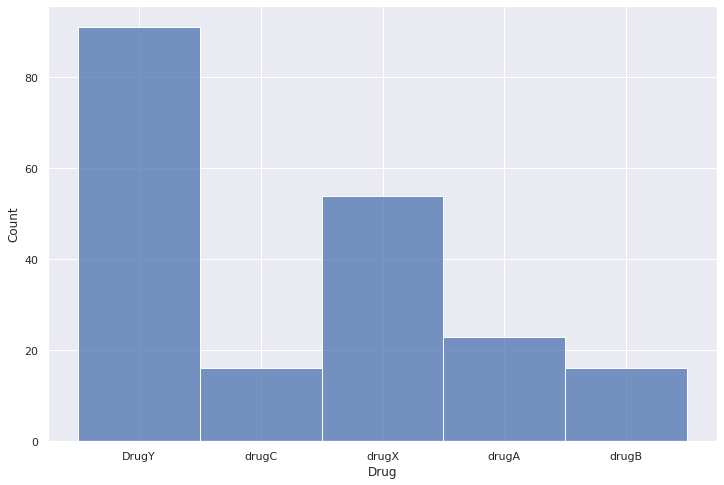

In [7]:
sns.histplot(data=df, x='Drug')
plt.show()

## 2. Visualization of entire dataset

<function matplotlib.pyplot.show(close=None, block=None)>

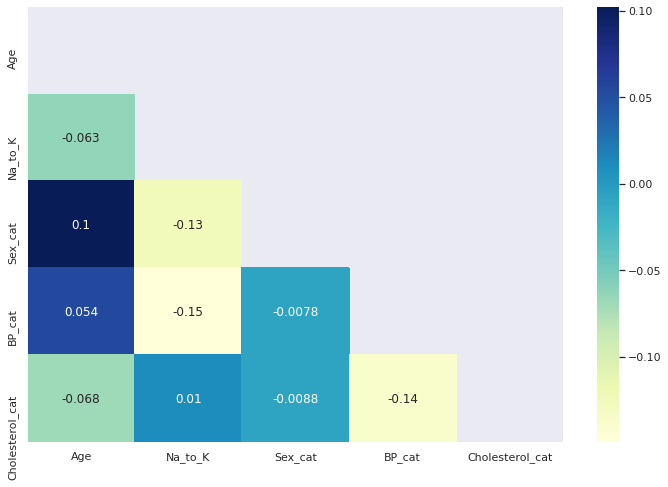

In [8]:
# Masking to show only one side of the matrix
corr = np.corrcoef(df.corr())                        
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Axtual Correlation matrix as a heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, cmap="YlGnBu")
plt.show

## 3. Relationship between Drug Cat and Na to Potassium Ration

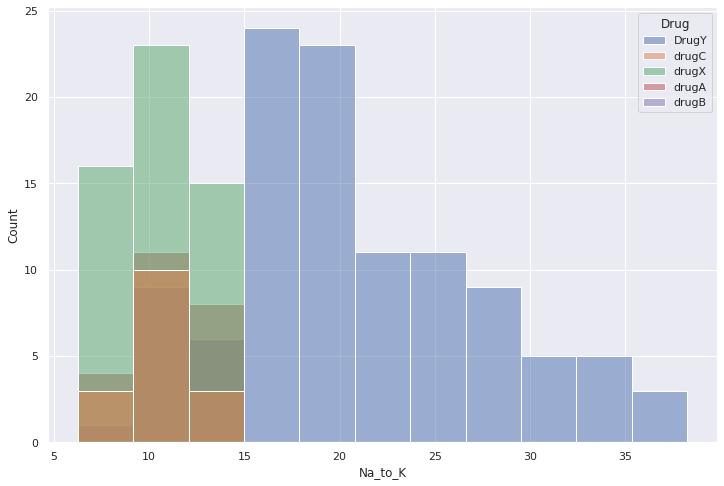

In [9]:
sns.histplot(data=df, x='Na_to_K', hue='Drug')
plt.show()

# Model Building & Evaluation

In [10]:
# Dictionary with model scores
models = {}

## 1. K-Nearest Neighbors

In [11]:
class knn():
    def __init__(self, df, target):
        self.df = df
        self.target = target
    
    def pre_processing(self):
        X = self.df.drop([self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.2, 
                                                            random_state = 2)
        return self
        
    def fit_pred_acc(self):
        # Elbow method to find best fit
        errors = {}    
        for k in range(1, 10):
            model_k = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(model_k, self.X_train, 
                                     self.Y_train, 
                                     cv=20, scoring='accuracy')
            errors[k] = scores.mean()
#         plt.plot(list(errors.keys()), list(errors.values()))
#         plt.xlabel('Value of K for KNN')
#         plt.ylabel('Cross-validated accuracy')
        k_best = max(errors.items(), key=op.itemgetter(1))[0]
        clf = KNeighborsClassifier(n_neighbors=k_best)
        clf.fit(self.X_train, self.Y_train)
        pred = clf.predict(self.X_test)
        print(skm.classification_report(self.Y_test, pred))
        return round(skm.accuracy_score(self.Y_test, pred), 2)

model = knn(df, 'Drug').pre_processing()
models['knn'] = model.fit_pred_acc()

              precision    recall  f1-score   support

       DrugY       0.92      1.00      0.96        22
       drugA       1.00      0.67      0.80         3
       drugB       0.75      1.00      0.86         3
       drugC       1.00      0.67      0.80         3
       drugX       1.00      0.89      0.94         9

    accuracy                           0.93        40
   macro avg       0.93      0.84      0.87        40
weighted avg       0.94      0.93      0.92        40



In [12]:
# Using utils
X, y = udp.pre_processing(df, 'Drug')
clf1 = clf.Classifier(X, y, 'knn')
clf1.preprocess_split(0.3, 62)
clf1.fit_predict()
print('For the training set:')
clf1.metrics(printing=True)

For the training set:
Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.65, 'Balanced Accuracy': 0.5421, 'AUC': 0.0, 'Precision': 0.6996, 'Recall': 0.65, 'F1_Score': 0.6263, 'log_loss': 3.9201}


## 2. Naive Bayes

In [13]:
class nb():
    def __init__(self, df, target):
        self.df = df
        self.target = target
    
    def pre_processing(self):
        X = self.df.drop([self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.25, 
                                                            random_state = 9)
        return self
        
    def fit_pred_acc(self):
        # Elbow method to find best fit
        clf = GaussianNB()
        clf.fit(self.X_train, self.Y_train)  
        pred = clf.predict(self.X_test)
        drug_names = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
        
        print(skm.classification_report(self.Y_test, pred, target_names=drug_names))
        return round(skm.accuracy_score(self.Y_test, pred), 2)

model = nb(df, 'Drug')
model = model.pre_processing()
models['nb'] = model.fit_pred_acc() 

              precision    recall  f1-score   support

       DrugY       1.00      0.89      0.94        18
       drugA       1.00      1.00      1.00         7
       drugB       0.80      1.00      0.89         4
       drugC       0.83      1.00      0.91         5
       drugX       1.00      1.00      1.00        16

    accuracy                           0.96        50
   macro avg       0.93      0.98      0.95        50
weighted avg       0.97      0.96      0.96        50



In [14]:
# Using utils
X, y = udp.pre_processing(df, 'Drug')
clf1 = clf.Classifier(X, y, 'guass_nb')
clf1.preprocess_split(0.3, 142)
clf1.fit_predict()
print('For the training set:')
clf1.metrics(printing=True)

For the training set:
Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.9333, 'Balanced Accuracy': 0.966, 'AUC': 0.0, 'Precision': 0.9438, 'Recall': 0.9333, 'F1_Score': 0.9351, 'log_loss': 0.3021}


## 3. Logistic Regression

In [15]:
class logreg():
    def __init__(self, df, target):
        self.df = df
        self.target = target
    
    def pre_processing(self):
        X = self.df.drop([self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.25, 
                                                            random_state = 16)
        return self
        
    def fit_pred_acc(self):
        # Elbow method to find best fit
        clf = LogisticRegression()
        clf.fit(self.X_train, self.Y_train)  
        pred = clf.predict(self.X_test)
        drug_names = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
        
        print(skm.classification_report(self.Y_test, pred, target_names=drug_names))
        return round(skm.accuracy_score(self.Y_test, pred), 2)
model = logreg(df, 'Drug')
model = model.pre_processing()
models['logreg'] = model.fit_pred_acc()

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        22
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00         4
       drugC       1.00      0.80      0.89         5
       drugX       0.93      1.00      0.97        14

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50



In [16]:
# Using utils
X, y = udp.pre_processing(df, 'Drug')
clf1 = clf.Classifier(X, y, 'log_reg')
clf1.preprocess_split(0.3, 62)
clf1.fit_predict()
print('For the training set:')
clf1.metrics(printing=True)

For the training set:
Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.8833, 'Balanced Accuracy': 0.8382, 'AUC': 0.0, 'Precision': 0.9312, 'Recall': 0.8833, 'F1_Score': 0.8936, 'log_loss': 0.2968}


## 4. Decision Tree

In [17]:
class tree():
    def __init__(self, df, target):
        self.df = df
        self.target = target
    
    def pre_processing(self):
        X = self.df.drop([self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.3, 
                                                            random_state = 2)
        return self
        
    def fit_pred_acc(self):
        # Elbow method to find best fit
        clf = DecisionTreeClassifier()
        clf.fit(self.X_train, self.Y_train)  
        pred = clf.predict(self.X_test)
        drug_names = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
        
        print(skm.classification_report(self.Y_test, pred, target_names=drug_names))
        return round(skm.accuracy_score(self.Y_test, pred), 2)
    
model = tree(df, 'Drug')
model = model.pre_processing()
models['tree'] = model.fit_pred_acc()

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        33
       drugA       1.00      1.00      1.00         8
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         3
       drugX       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [18]:
# Using utils
X, y = udp.pre_processing(df, 'Drug')
clf1 = clf.Classifier(X, y, 'tree')
clf1.preprocess_split(0.3, 142)
clf1.fit_predict()
print('For the training set:')
clf1.metrics(printing=True)

For the training set:
Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.9833, 'Balanced Accuracy': 0.99, 'AUC': 0.0, 'Precision': 0.984, 'Recall': 0.9833, 'F1_Score': 0.9833, 'log_loss': 0.5756}


## 5. Support Vector Classifier

In [19]:
class svc():
    def __init__(self, df, target):
        self.df = df
        self.target = target
    
    def pre_processing(self):
        X = self.df.drop([self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.15, 
                                                            random_state = 64)
        return self
        
    def fit_pred_acc(self):
        # Elbow method to find best fit
        clf = SVC(gamma='auto')
        clf.fit(self.X_train, self.Y_train)  
        pred = clf.predict(self.X_test)
        drug_names = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
        
        print(skm.classification_report(self.Y_test, pred, target_names=drug_names))
        return round(skm.accuracy_score(self.Y_test, pred), 2)
    
model = svc(df, 'Drug')
model = model.pre_processing()
models['svc'] = model.fit_pred_acc()

              precision    recall  f1-score   support

       DrugY       0.87      1.00      0.93        13
       drugA       1.00      1.00      1.00         2
       drugB       1.00      1.00      1.00         1
       drugC       0.00      0.00      0.00         2
       drugX       0.92      0.92      0.92        12

    accuracy                           0.90        30
   macro avg       0.76      0.78      0.77        30
weighted avg       0.84      0.90      0.87        30



In [20]:
# Using utils
# X, y = udp.pre_processing(df, 'Drug')
# clf1 = clf.Classifier(X, y, 'svc')
# clf1.preprocess_split(0.3, 62)
# clf1.fit_predict()
# print('For the training set:')
# clf1.metrics(printing=True)

In [21]:
scores_df = pd.DataFrame.from_dict(models, orient='index', 
                              columns = ['accuracy'])
scores_df

,accuracy
knn,0.92
nb,0.96
logreg,0.98
tree,1.00
svc,0.90
